# Assignment 2 - Machine Learning
**Project:** Project 1 - Classify Images of Road Traffic Signs

**Group Name:** Dan & Ethan
| Name               | Student Number |
|--------------------|----------------|
| Daniel Schellekens | s3900792       |
| Ethan Rayner       | s3902240       |

In [1]:
IMAGES_FILE = "images.csv"
TEST_TRAIN_SPLIT = 0.2
IMAGE_SIZE = 28
TEST_SIZE = 128

from models.utils import prep_data

data, train_data, val_data = prep_data(IMAGES_FILE, TEST_TRAIN_SPLIT)
data.head()

Training set: 2959 rows
Validation set: 740 rows


,path,shape,type
0,images\diamond\rightofway\00032_00000.png,diamond,rightofway
1,images\diamond\rightofway\00032_00001.png,diamond,rightofway
2,images\diamond\rightofway\00032_00002.png,diamond,rightofway
3,images\diamond\rightofway\00037_00000.png,diamond,rightofway
4,images\diamond\rightofway\00037_00001.png,diamond,rightofway


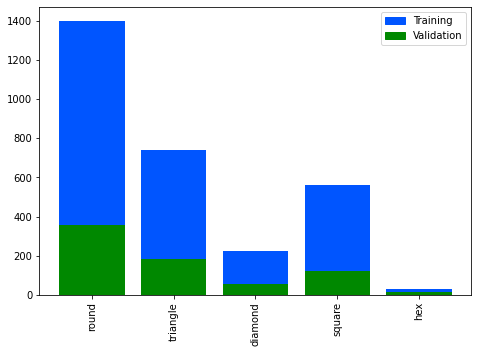

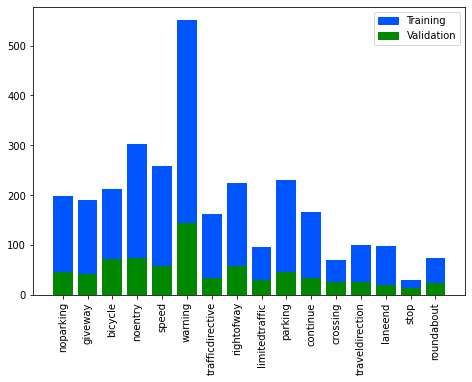

In [2]:
from models.eda import classes_histogram

classes_histogram(train_data, val_data, "shape")
classes_histogram(train_data, val_data, "type")

## Training the Model
ImageDataGenerators are used to generate training and validation images that aren't always identical to the originals in the `images/` directory. A series of random translations, scaling, rotations and brightness shifts are applied to the images first. This ensures that as the model trains during the numerous epochs, it is seeing somewhat fresh data not repeated information that it could overfit to.

### Model 2 - AlexNet

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


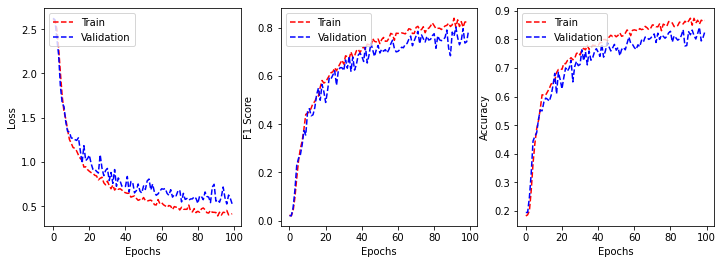

Overall F1 Macro Score: 0.7994

F1 Scores per class: bicycle = 0.7407, continue = 0.8219, crossing = 0.8696, giveway = 0.9367, laneend = 0.7778, limitedtraffic = 0.8000, noentry = 0.8857, noparking = 0.7805, parking = 0.8454, rightofway = 0.7931, roundabout = 0.6500, speed = 0.8099, stop = 0.5217, trafficdirective = 0.8136, traveldirection = 0.8077, warning = 0.9365

In [3]:
CLASS_COLUMN = "type"
BATCH_SIZE = 32
EPOCHS = 100

import models.alexnet as alex
from models.utils import history_graph
from models.utils import create_generator
from models.test import score_f1

alex_train_images = create_generator(train_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
alex_val_images = create_generator(val_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
alex_model, alex_history = alex.fit_model(data, CLASS_COLUMN, alex_train_images, alex_val_images, IMAGE_SIZE, EPOCHS)
history_graph(alex_history)
score_f1(alex_model, alex_val_images, TEST_SIZE)

### Model 3 - Modified VGGNet


Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


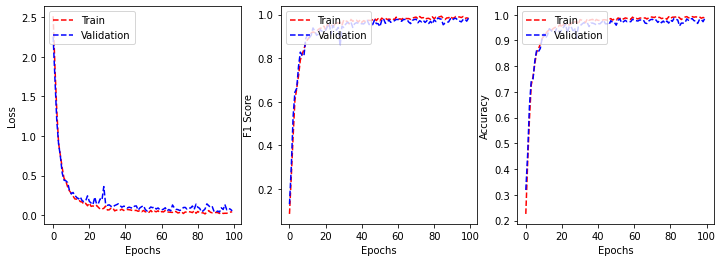

Overall F1 Macro Score: 0.9821

F1 Scores per class: bicycle = 0.9930, continue = 1.0000, crossing = 0.9804, giveway = 0.9880, laneend = 1.0000, limitedtraffic = 0.9655, noentry = 0.9863, noparking = 0.9778, parking = 1.0000, rightofway = 0.9913, roundabout = 0.9333, speed = 1.0000, stop = 1.0000, trafficdirective = 0.9394, traveldirection = 0.9615, warning = 0.9965

In [4]:
EPOCHS = 100

import models.vggnet as vgg

vgg_train_images = create_generator(train_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
vgg_val_images = create_generator(val_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
vgg_model, vgg_history = vgg.fit_model(data, CLASS_COLUMN, vgg_train_images, vgg_val_images, IMAGE_SIZE, EPOCHS)
history_graph(vgg_history)
score_f1(vgg_model, vgg_val_images, TEST_SIZE)

## Independent Evaluation
The final results are determined from an independent dataset of 80 images (5 of each class) sourced from Street Imagery made available by KartaView under a Creative Commons Attribution-ShareAlike 4.0 International ([https://kartaview.org/terms](https://kartaview.org/terms)). These images have been pre-processed to match the 28x28 dimensions and greyscale colors of the original dataset. This tests the performance of the model on unseen "real-world" data.

In [5]:
NUM_TO_VISUALIZE = 20
NUM_TO_F1_SCORE = 100
IMAGES_FILE = "test-images.csv"

from models.test import create_test_generator
from models.test import show_visual_results

test_images = create_test_generator(IMAGES_FILE, CLASS_COLUMN, IMAGE_SIZE, NUM_TO_F1_SCORE)
test_images_single_batch = create_test_generator(IMAGES_FILE, CLASS_COLUMN, IMAGE_SIZE, 1)

Found 80 validated image filenames belonging to 16 classes.
Found 80 validated image filenames belonging to 16 classes.


Overall F1 Macro Score: 0.6002

F1 Scores per class: bicycle = 0.4615, continue = 0.9091, crossing = 0.8000, giveway = 1.0000, laneend = 0.7500, limitedtraffic = 0.5714, noentry = 0.8889, noparking = 0.5000, parking = 0.6000, rightofway = 0.5333, roundabout = 0.2500, speed = 0.4286, stop = 0.2222, trafficdirective = 0.2222, traveldirection = 0.6667, warning = 0.8000

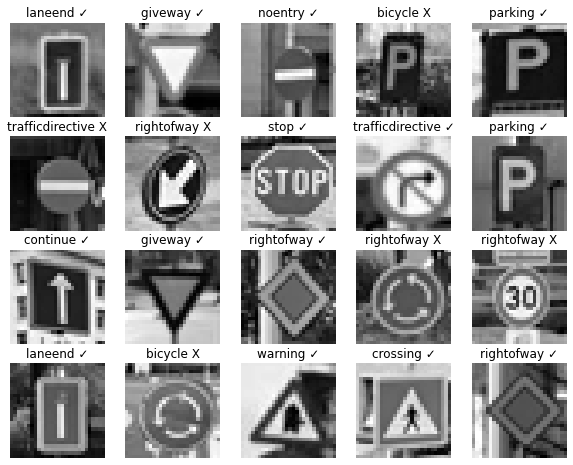

In [6]:
show_visual_results(alex_model, test_images_single_batch, NUM_TO_VISUALIZE)
score_f1(alex_model, test_images, TEST_SIZE)

Overall F1 Macro Score: 0.9361

F1 Scores per class: bicycle = 1.0000, continue = 0.9091, crossing = 1.0000, giveway = 1.0000, laneend = 0.8889, limitedtraffic = 1.0000, noentry = 1.0000, noparking = 0.8889, parking = 0.9091, rightofway = 0.8333, roundabout = 1.0000, speed = 1.0000, stop = 1.0000, trafficdirective = 0.8889, traveldirection = 0.7500, warning = 0.9091

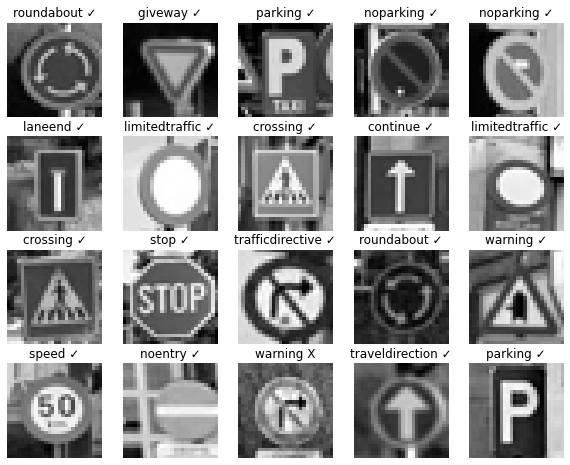

In [7]:
show_visual_results(vgg_model, test_images_single_batch, NUM_TO_VISUALIZE)
score_f1(vgg_model, test_images, TEST_SIZE)